In [61]:
#----------------------------------
# Paquetes que vamos a usar
#----------------------------------

import psrchive
import matplotlib.pyplot as plt
import numpy as np
import glob
import subprocess
import decimal

import os
import shutil

import matplotlib.mlab as mlab
import matplotlib as mpl
import matplotlib.pyplot as plt     # para graficar
from matplotlib import pyplot
from matplotlib import rc

In [2]:
ant = 'A1'        # antena usada (A1 o A2)

In [3]:
#----------------------------------------
# Función que da los argumentos para pat
#----------------------------------------
def pat_args_subt(nsubint):

# Choose a given template named 'pulsar.pfd.std'

    usingtemplate = './template_' + ant +'.std'
    
    return '-A PGS -f "tempo2" -s {} -jFD -j "T {}" '.format(usingtemplate,nsubint)

In [4]:
#----------------------------------
# Cargamos las observaciones
#----------------------------------

timing_folder = './' + ant + '/'                   # nombre del directorio que contiene los .pfds
os.chdir(timing_folder)                            # entramos al directorio que contiene los .pfds
pfds = glob.glob('*pfd')                           # creamos una lista que contiene los .pfds

archivos = ''
for pfd in pfds:                                   # creamos un string con los nombres de los .pfds
    archivos = archivos + pfd + ' '
    
#creamos las carpetas que contendrán los resultados

dirName = "./single_pulses"                        # nombre de la carpeta en que guardaremos los resultados
if not os.path.exists(dirName):
    os.mkdir(dirName)                              # si la carpeta no existe desde antes, la creamos
    
os.chdir('..')                                     # salimos del directorio que contiene los .pfds

Los errores de los TOAs los guardaremos en un array de dos dimensiones, donde cada columna se corresponde a cada uno de los números de subintegraciones usados, y donde cada fila se corresponde a una sub-observación particular

In [9]:
err_toas = np.full([128 * len(pfds) , 4], -1.)  # array de 2 dimensiones que contendrá los errores de los TOAs
n_subint = np.zeros(4)                          # array de 1 dimensión que contendrá el número de sub-integraciones

rango_subints = [1]
rango_criterio = [1.25,1.0,0.75,0.5]

array_criterio = np.zeros(len(rango_criterio))
array_RMS = np.zeros(len(rango_criterio))
array_npuntos = np.zeros(len(rango_criterio))

Ahora vamos a calcular los TOAs y los errores de cada sub-integración de cada observación. Ahora bien, si se intentaba primero calcular los TOAs de todas las observaciones juntas y volcarlos a un archivo de salida, entonces para más de 64 sub-integraciones el archivo resultante era demasiado grande y no toda la información era grabada. Por lo tanto, opté por calcular los TOAs de las sub-integraciones de una observación por vez, volcar la información a un archivo de salida, levantar esos datos, y después seguir con la siguiente observación reescribiendo el archivo de salida en cada iteración.

NOTA: Hay observaciones tanto de A1 como de A2 reducidas con 60 subintegraciones, de modo que usar más 60 sub-integraciones no sirve.

In [20]:
os.chdir('..')

In [16]:
#for j in range(0,4):                     # Barremos todos los números de sub-integraciones
for j in rango_subints:
    
    if j == 0:                            # En caso de no hacer sub-integraciones
        nsubints_t = 1
    else:                                 # En caso de hacer sub-integraciones, el número de sub-integraciones para A2 debe ser un divisor de 60.
        nsubints_t = 20 * j               # En este caso escogemos 16, 32, 64.
    
    n_subint[j] = int(nsubints_t)         # Guardamos en un array el número de subintegraciones usadas
    
#----------------------------------------------------------------------------------------------------------------------------------------
# Creamos los archivos .tim de salida para cada uno de los criterios usados
#----------------------------------------------------------------------------------------------------------------------------------------

    for criterio in rango_criterio:
        tim_out = dirName + '/subints_nsub' + str(nsubints_t) + '_crit' + str(int(criterio*100)) + '.tim' # nombre del archivo de salida
        f = open(tim_out, "w")                                                                           # abrimos el nuevo archivo .tim
        f.write("FORMAT 1" + '\n')
        f.close()

    subints_t_toa= dirName + '/subints_' + str(nsubints_t) + '.tim'   # nombre del archivo .tim de salida

    pat_output_subints_t= ' >{}'.format(subints_t_toa)

#----------------------------------------------------------------------------------------------------------------------------------------
# Calculamos los TOAs y los errores de cada observación
#----------------------------------------------------------------------------------------------------------------------------------------

    os.chdir(timing_folder)               # Entramos al directorio que contiene los .pfds     
            
    k = 0                                 # Este contador k nos indicará el número de la observación que estamos usando
    for pfd in pfds:                      # Barremos todas las observaciones
        
        # Calculamos los TOAs de esta observación particular
        subprocess.call(['pat '+pat_args_subt(nsubints_t)+pfd+pat_output_subints_t], shell=True)
#        print('pat '+pat_args_subt(nsubints_t)+pfd+pat_output_subints_t)
                        
        # Leemos los datos de los TOAs de esta observación particular
        file = np.loadtxt( subints_t_toa , skiprows=1 , dtype=str , usecols=(0) )             # nombre de cada observación
        freq = np.loadtxt( subints_t_toa, skiprows=1, dtype=float , usecols=(1) )             # frecuencia de la observación
        MJD = np.loadtxt( subints_t_toa , skiprows=1 , dtype=decimal.Decimal , usecols=(2) )  # fecha juliana modificada de la observación
        err = np.loadtxt( subints_t_toa , skiprows=1 , dtype=float,  usecols=(3) )            # error en el TOA
        telescope = np.loadtxt( subints_t_toa, skiprows=1, dtype=str, usecols=(4) )           # antena usada (A1 o A2)    
        
        print(k)
        
        # Si el error es menor al criterio utilizado, entonces escribimos los datos en el archivo .tim de salida
        
        for criterio in rango_criterio:  # Barremos los diferentes criterios utilizados
            
            tim_out = dirName + '/subints_nsub' + str(nsubints_t) + '_crit' + str(int(criterio*100)) + '.tim' # nombre del archivo de salida
            
            if j == 0:                                   # Si no utilizamos sub-integraciones entonces el error calculado es único
                if err < criterio:
                    with open(tim_out, "a") as f:
                        f.write( str(file) + ' ' + '{:11.6f}'.format(freq) + ' ' + str(MJD) + '   ' + '{:5.3f}'.format(err) + '  ' + str(telescope) + '\n')
                    
            else:                                        # Si sí usamos sub-integraciones entonces los errores calculados son múltiples
                for x in range(len(err)):
                    if err[x] < criterio:
                        with open(tim_out, "a") as f:
                            f.write( str(file[x]) + ' ' + '{:11.6f}'.format(freq[x]) + ' ' + str(MJD[x]) + '   ' + '{:5.3f}'.format(err[x]) + '  ' + str(telescope[x]) + '\n')      
                        
#----------------------------------------------------------------------------------------------------------------------------------------
# Almacenamos los errores en el array de errores
#----------------------------------------------------------------------------------------------------------------------------------------        
        
        if j == 0:                                       # Si no utilizamos sub-integraciones entonces el error calculado 
            err_toas[k * nsubints_t,j] = err             # es único, de modo que fue leído como un escalar
            
        else:
            for i in range(len(err)):                    # Si sí usamos sub-integraciones entonces los errores calculados
                err_toas[i + k * nsubints_t,j] = err[i]  # son múltiples, así que fueron leídos como un vector
        
        k += 1                                           # Aumentamos en 1 el contador de la observación que estamos usando    
    
    os.chdir('..')                         # Salimos del directorio que contiene los .pfds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [51]:
#----------------------------------------------------------------------------------------------------------------------------------------
# Calculamos los residuos
#----------------------------------------------------------------------------------------------------------------------------------------        

for j in rango_subints:
    
    os.chdir(timing_folder)               # Entramos al directorio que contiene los .pfds  
    
    if j == 0:                            # En caso de no hacer sub-integraciones
        nsubints_t = 1
    else:                                 # En caso de hacer sub-integraciones, el número de sub-integraciones para A2 debe ser un divisor de 60.
        nsubints_t = 20 * j               # En este caso escogemos 16, 32, 64.
    
    k=0
    for criterio in rango_criterio:  # Barremos los diferentes criterios utilizados
        
        array_criterio[k] = criterio
        
        tim_out = dirName + '/subints_nsub' + str(nsubints_t) + '_crit' + str(int(criterio*100)) + '.tim' # nombre del archivo de salida
        err = np.loadtxt( tim_out , skiprows=1 , dtype=float,  usecols=(3) )
        array_npuntos[k] = len(err)
        
        resfile = dirName + "/residues.dat"                      # nombre del archivo de residuos
        
        subprocess.check_call( "tempo2 >" + resfile + " -us -f J0437-4715.par " + tim_out, shell = True)  # calculamos los residuos
            
        array_RMS[k] = np.genfromtxt ( resfile, comments="none", dtype=float, skip_header=18, max_rows=1, usecols=(10) ) # buscamos el RMS
        
        k += 1
        
    os.chdir('..')                         # Salimos del directorio que contiene los .pfds

(20, 1554)
(20, 1278)
(20, 771)
(20, 291)
[1554. 1278.  771.  291.]


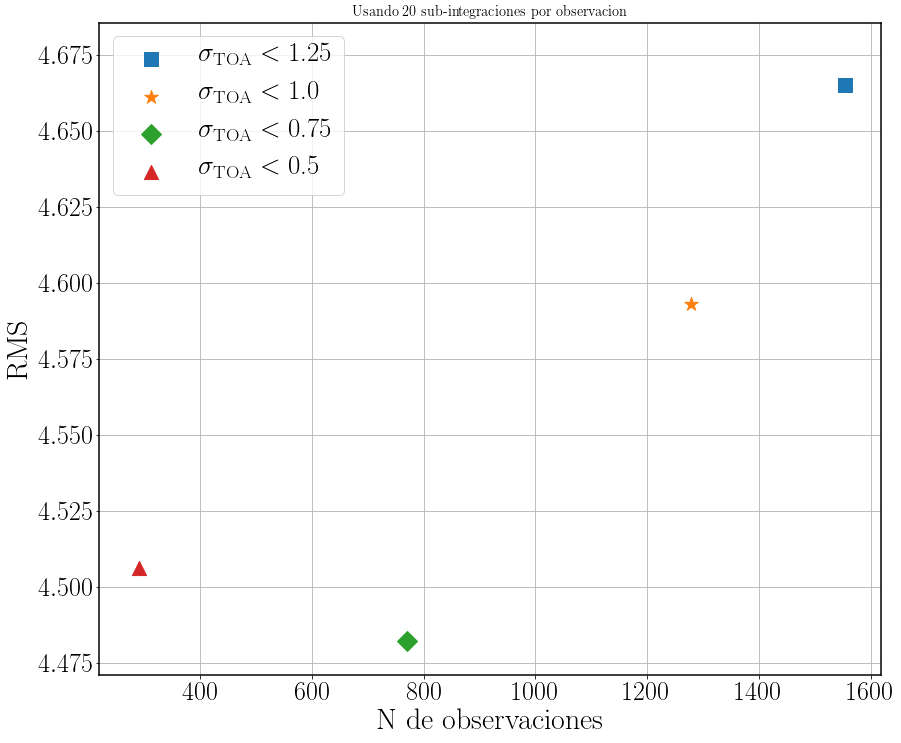

In [96]:
#----------------------------------------------------------------------------------------------------------------------------------------
# Graficamos los resultados
#----------------------------------------------------------------------------------------------------------------------------------------        

plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 26,
        "ytick.labelsize": 26,
}
# Update the fonts
mpl.rcParams.update(nice_fonts) 

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size="12")
plt.rc('lines', linewidth=1.2)

#plt.xlim(10, 220)     # set the xlim to left, right
#plt.xticks([10, 50, 100, 150, 200])

plt.figure(figsize=(14,12))
plt.grid()

error_bar = [array_criterio, array_criterio]

plt.scatter(array_npuntos[0], array_RMS[0], s=200, marker="s", label='$\sigma_{\mathrm{TOA}} <$ ' + str(array_criterio[0]))
plt.scatter(array_npuntos[1], array_RMS[1], s=200, marker="*", label='$\sigma_{\mathrm{TOA}} <$ ' + str(array_criterio[1]))
plt.scatter(array_npuntos[2], array_RMS[2], s=200, marker="D", label='$\sigma_{\mathrm{TOA}} <$ ' + str(array_criterio[2]))
plt.scatter(array_npuntos[3], array_RMS[3], s=200, marker="^", label='$\sigma_{\mathrm{TOA}} <$ ' + str(array_criterio[3]))
#plt.errorbar(array_npuntos, array_RMS, error_bar, fmt='o', capthick=3, capsize=5, lw=5)

plt.legend( loc='upper left', fontsize=27)

plt.title('Usando ' + str(nsubints_t) + ' sub-integraciones por observacion')
plt.xlabel('N de observaciones')
plt.ylabel('RMS')
#plt.savefig('./single_pulses/RMS_' + str(nsubints_t) + '.pdf', bbox_inches='tight')
plt.savefig('./single_pulses/RMS_' + str(nsubints_t) + '.png', bbox_inches='tight')
plt.show()

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


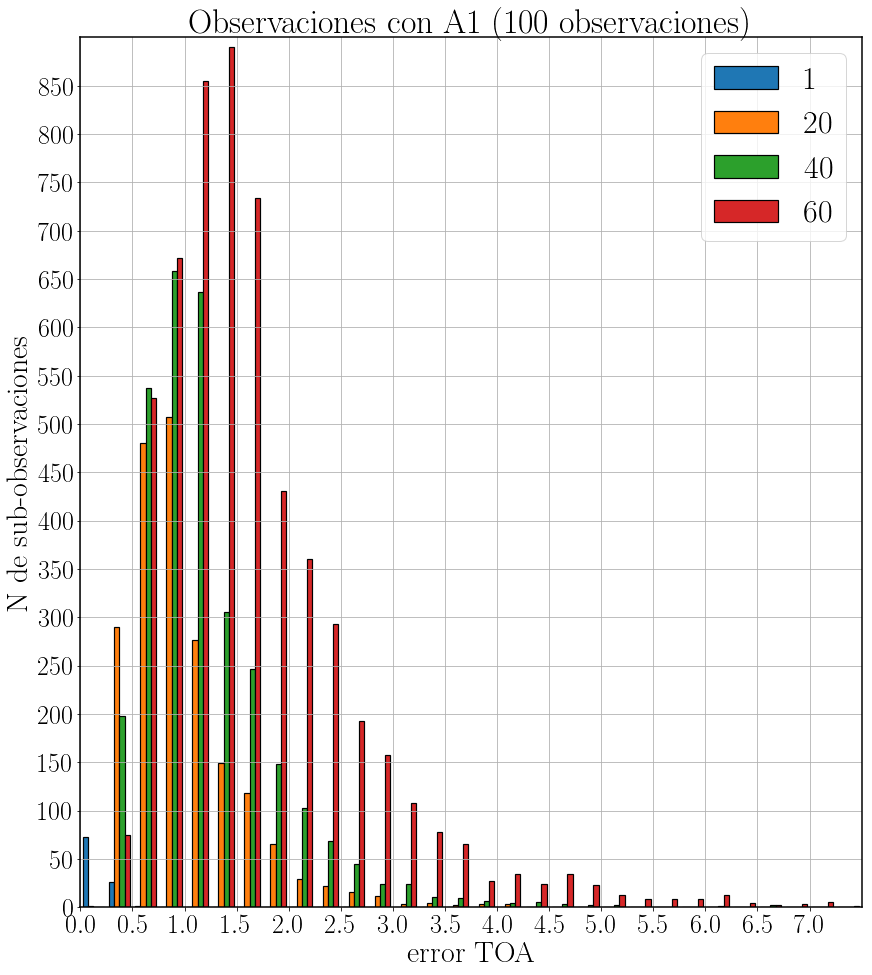

In [22]:
#----------------------------------
# Graficamos los resultados
#----------------------------------

plt.close()

# Set the fonts. Always use big fonts.
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 30,
        "font.size": 28,
        "axes.linewidth": 1.5,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 32,
        "xtick.labelsize": 26,
        "ytick.labelsize": 26,
}
# Update the fonts
mpl.rcParams.update(nice_fonts)


plt.figure(figsize=(14,16))
plt.grid()


if ant == 'A1':
    plt.xlim((0.0, 7.5))
    plt.ylim((0, 900))
    plt.xticks(np.arange(0, 7.5, 0.5))
    plt.yticks(np.arange(0, 900, 50))
    bin_size = 0.25
    min_edge = 0.0
    max_edge = 7.5

if ant == 'A2':
    plt.xlim((0.0, 6.5))
    plt.ylim((0.0, 1450.0))
    plt.xticks(np.arange(0, 6.5, 0.5))
    plt.yticks(np.arange(0, 1450, 50))
    bin_size = 0.25
    min_edge = 0.0
    max_edge = 6.5

N = (max_edge-min_edge)/bin_size
Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

plt.hist([err_toas[:,0],err_toas[:,1],err_toas[:,2],err_toas[:,3]], bin_list, edgecolor='black', linewidth=1.2, label=[n_subint[0],n_subint[1],n_subint[2],n_subint[3]])

plt.legend(loc='upper right')

plt.title('Observaciones con ' + ant + ' (' + str(len(pfds)) + ' observaciones)')
plt.xlabel('error TOA')
plt.ylabel('N de sub-observaciones')
plt.savefig('./single_pulses/histograma_subint_ ' + ant + '.pdf', bbox_inches='tight')
plt.savefig('./single_pulses/histograma_subint_ ' + ant + '.png', bbox_inches='tight')
plt.show()